In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
%matplotlib inline
warnings.filterwarnings('ignore', category= DeprecationWarning)

## Importing Data

In [2]:
dataset = pd.read_csv('MBA_gaming_shop_transactions_updated.csv')

In [3]:
dataset.head(100)

,InvoiceNo,ItemName,Quantity,Timestamp,Price
0,INV-20000,Processor,4.0,2024-07-16 09:58:59,327.85
1,INV-20000,Gaming Backpack,1.0,2024-07-16 09:58:59,1698.04
2,INV-20000,Gaming Microphone,1.0,2024-07-16 09:58:59,211.50
3,INV-20001,Motherboard,3.0,2024-12-12 03:54:46,1020.60
4,INV-20001,Gaming Desk,2.0,2024-12-12 03:54:46,1622.67
...,...,...,...,...,...
95,INV-20026,Gaming Microphone,2.0,2025-03-27 01:33:11,211.50
96,INV-20027,Gaming Desk,4.0,2024-10-30 12:10:40,1622.67
97,INV-20028,Mouse Pad,4.0,2024-12-22 23:33:04,413.70
98,INV-20028,Mouse Pad,2.0,2024-12-22 23:33:04,413.70


In [4]:
print(dataset.head(1000).to_string())

     InvoiceNo             ItemName  Quantity            Timestamp    Price
0    INV-20000            Processor       4.0  2024-07-16 09:58:59   327.85
1    INV-20000      Gaming Backpack       1.0  2024-07-16 09:58:59  1698.04
2    INV-20000    Gaming Microphone       1.0  2024-07-16 09:58:59   211.50
3    INV-20001          Motherboard       3.0  2024-12-12 03:54:46  1020.60
4    INV-20001          Gaming Desk       2.0  2024-12-12 03:54:46  1622.67
5    INV-20001           VR Headset       3.0  2024-12-12 03:54:46  1786.52
6    INV-20001         Gaming Chair       3.0  2024-12-12 03:54:46   564.56
7    INV-20001           VR Headset       2.0  2024-12-12 03:54:46  1786.52
8    INV-20002    Surround Speakers       4.0  2024-09-20 22:49:53  1215.38
9    INV-20002              SSD 1TB       2.0  2024-09-20 22:49:53  1478.21
10   INV-20003           CPU Cooler       1.0  2025-04-08 08:41:07   855.41
11   INV-20003         Capture Card       NaN  2025-04-08 08:41:07  1186.75
12   INV-200

## Understanding for how many rows item name is wrong or missing 

In [5]:
dataset['ItemName'].value_counts(dropna = False)

Gaming Mouse           360
Joystick               354
Streaming Webcam       353
Power Supply           349
VR Headset             339
Motherboard            336
Gaming Chair           335
Gaming Backpack        333
Mouse Pad              332
Gaming Laptop          330
Capture Card           329
Gamepad                329
Gaming Microphone      329
CPU Cooler             328
Graphics Card          328
Sound Card             327
Processor              326
RAM 16GB               324
SSD 1TB                322
RAM 32GB               321
Gaming Controller      320
Gaming Headset         319
Gaming Desk            318
RGB Lighting Kit       318
Gaming Glasses         316
External Hard Drive    312
Gaming Monitor         309
Surround Speakers      306
Mechanical Keyboard    304
WiFi Router            298
NaN                    196
Name: ItemName, dtype: int64

## From the table above, it is clear that there are 196 rows where item name is missing and there are no rows where item name is wrong

## Below I try to understand if any invoice code is incorrect or missing. Every invoice code should be of the form 'INV-?????' where '?' represents a digit from 0 to 9 

In [6]:
# The result will show that there is no row with incorrect or missing invoice code 
dataset[~dataset['InvoiceNo'].str.fullmatch(r'INV-\d{5}')]

,InvoiceNo,ItemName,Quantity,Timestamp,Price


## The line executed above provided an empty data frame. Therefore, I can conclude that all invoice codes are in the correct format.

## In the code below the aim is to see whether the invoices and transactions are correctly organized. Normally, an invoice code should belong to a single transaction and there is a unique timestamp correspong to the transaction. Therefore, rows having the same invoice code should have the same timestamp.

In [7]:
dataset.groupby(['InvoiceNo']).size()

InvoiceNo
INV-20000    3
INV-20001    5
INV-20002    2
INV-20003    3
INV-20004    3
            ..
INV-23361    2
INV-23362    5
INV-23363    5
INV-23364    4
INV-23365    1
Length: 3366, dtype: int64

In [8]:
dataset.groupby(['InvoiceNo','Timestamp']).size()

InvoiceNo  Timestamp          
INV-20000  2024-07-16 09:58:59    3
INV-20001  2024-12-12 03:54:46    5
INV-20002  2024-09-20 22:49:53    2
INV-20003  2025-04-08 08:41:07    3
INV-20004  2024-12-28 15:07:08    3
                                 ..
INV-23361  2025-02-23 22:44:50    2
INV-23362  2025-03-13 08:37:48    5
INV-23363  2025-01-27 12:41:14    5
INV-23364  2024-10-10 21:32:20    4
INV-23365  2024-11-09 16:19:47    1
Length: 3366, dtype: int64

## In both cases above, the length of series obtained is 3366. Therefore, I can conclude that the transactions were correctly organized.

## Below, I remove the rows where item name is missing since they can not be used in my analysis. 
## There can be rows where the quantity or price entries are missing, but the existence of transaction shows that the corresponding item was purchased. Therefore, such entries are relevant to my analysis.

In [9]:
dataset.dropna(subset=['ItemName'], inplace=True)

## Below, filling all the missing entries in column Quantity with 1 because it will be important during the one-hot encoding phase. The amount in each cell regarding the column Quantity is not important, as long as it is not zero.

In [10]:
dataset['Quantity'].fillna(1, inplace = True)

# Now the data set is clear. I can continue with the necessary data transformations.

In [11]:
dataset_prep = dataset.groupby(['InvoiceNo','ItemName'])['Quantity'].sum().unstack()

In [12]:
dataset_prep.fillna(0, inplace = True)

In [13]:
# Defining a function for encoding 
def encoding(x):
     if x == 0 :
        return 0
     else :   
        return 1

In [14]:
dataset_ready = dataset_prep.applymap(encoding)

In [15]:
dataset_ready

ItemName,CPU Cooler,Capture Card,External Hard Drive,Gamepad,Gaming Backpack,Gaming Chair,Gaming Controller,Gaming Desk,Gaming Glasses,Gaming Headset,...,Processor,RAM 16GB,RAM 32GB,RGB Lighting Kit,SSD 1TB,Sound Card,Streaming Webcam,Surround Speakers,VR Headset,WiFi Router
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
INV-20000,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
INV-20001,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
INV-20002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
INV-20003,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INV-20004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INV-23361,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
INV-23362,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
INV-23363,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,0


## Now making a plot in order to decide which value for min_support parameter of apriori algorithm would be suitable. The intention is to find a value for which there would not be too many or too few frequent items.

In [16]:
support_values = []
number_of_itemsets = []
for support in [0.005, 0.007, 0.009 , 0.001, 0.01 , 0.02 , 0.05, 0.1, 0.2, 0.3 , 0.4, 0.5 ]:
    support_values.append(support)
    frequent_itemsets = apriori(dataset_ready, min_support = support, use_colnames = True )
    number_of_itemsets.append(frequent_itemsets['itemsets'].count())

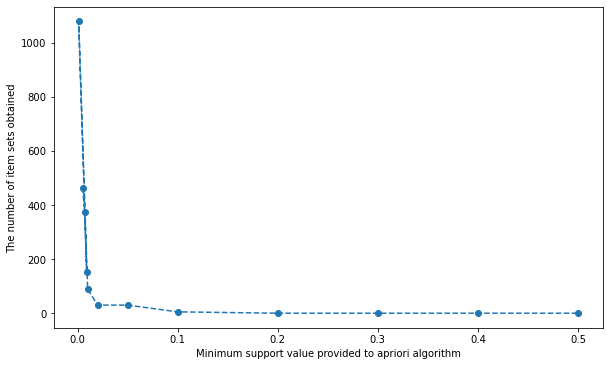

In [17]:
cm = 1/2.54
plt.figure(figsize = (25*cm,15*cm))

plt.plot(support_values, number_of_itemsets, marker = 'o', linestyle = '--')
plt.xlabel('Minimum support value provided to apriori algorithm')
plt.ylabel('The number of item sets obtained');

# As we can see from the plot above after the value 0.1 the algorithm does not provide any item set. Therefore, in order to determine a suitable minimum support value. I will provide a second plot containing support values from 0.005 up to 0.06

In [18]:
support_values2 = []
number_of_itemsets2 = []
support=0.005
while support <= 0.06:
    support_values2.append(support)
    frequent_itemsets = apriori(dataset_ready, min_support = support, use_colnames = True )
    number_of_itemsets2.append(frequent_itemsets['itemsets'].count())
    support = support + 0.002

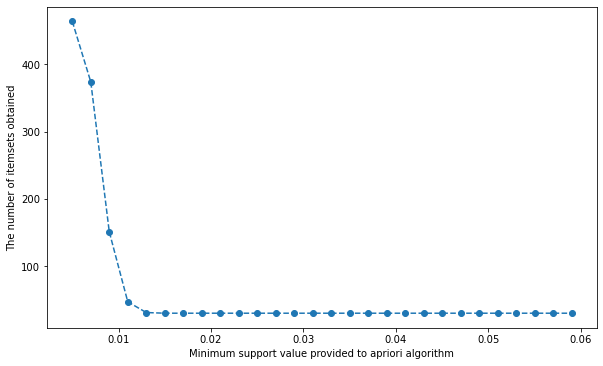

In [19]:
cm = 1/2.54
plt.figure(figsize = (25*cm,15*cm))

plt.plot(support_values2, number_of_itemsets2, marker = 'o', linestyle = '--')
plt.xlabel('Minimum support value provided to apriori algorithm')
plt.ylabel('The number of itemsets obtained');

# As a result of the plot above, I believe that value of 0.011 would be a suitable value for the apriori algorithm. Therefore we have:

In [20]:
frequent_items = apriori(dataset_ready, min_support = 0.011, use_colnames = True)

In [21]:
frequent_items

,support,itemsets
0,0.095637,(CPU Cooler)
1,0.097131,(Capture Card)
2,0.091452,(External Hard Drive)
3,0.096234,(Gamepad)
4,0.097729,(Gaming Backpack)
5,0.097430,(Gaming Chair)
6,0.094441,(Gaming Controller)
7,0.092349,(Gaming Desk)
8,0.091751,(Gaming Glasses)
9,0.094740,(Gaming Headset)


## Now I can obtain the association rules

In [22]:
rules = association_rules(frequent_items, metric = 'lift', min_threshold = 1.2 )

In [23]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Capture Card),(Power Supply),0.097131,0.100120,0.013449,0.138462,1.382962,0.003724,1.044504,0.306705
1,(Power Supply),(Capture Card),0.100120,0.097131,0.013449,0.134328,1.382962,0.003724,1.042969,0.307724
2,(RAM 32GB),(Capture Card),0.094740,0.097131,0.011058,0.116719,1.201669,0.001856,1.022177,0.185388
3,(Capture Card),(RAM 32GB),0.097131,0.094740,0.011058,0.113846,1.201669,0.001856,1.021561,0.185879
4,(Gaming Backpack),(Gaming Glasses),0.097729,0.091751,0.011955,0.122324,1.333214,0.002988,1.034834,0.277004
5,(Gaming Glasses),(Gaming Backpack),0.091751,0.097729,0.011955,0.130293,1.333214,0.002988,1.037443,0.275181
6,(Gaming Headset),(Gaming Controller),0.094740,0.094441,0.011656,0.123028,1.302699,0.002708,1.032598,0.256681
7,(Gaming Controller),(Gaming Headset),0.094441,0.094740,0.011656,0.123418,1.302699,0.002708,1.032715,0.256596
8,(Gaming Controller),(Processor),0.094441,0.095935,0.012851,0.136076,1.418412,0.003791,1.046463,0.325750
9,(Processor),(Gaming Controller),0.095935,0.094441,0.012851,0.133956,1.418412,0.003791,1.045627,0.326289


## All the association rules found by the algorithm have low support and confidence. In this situation, I would take top 5 rules with highest lift values. So, the rules obtained by the association analysis are as follows.

In [24]:
rules.sort_values(by=['lift'], ascending = False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
8,(Gaming Controller),(Processor),0.094441,0.095935,0.012851,0.136076,1.418412,0.003791,1.046463,0.325750
9,(Processor),(Gaming Controller),0.095935,0.094441,0.012851,0.133956,1.418412,0.003791,1.045627,0.326289
11,(Gaming Glasses),(Gaming Monitor),0.091751,0.091154,0.011656,0.127036,1.393646,0.003292,1.041104,0.310991
10,(Gaming Monitor),(Gaming Glasses),0.091154,0.091751,0.011656,0.127869,1.393646,0.003292,1.041413,0.310787
0,(Capture Card),(Power Supply),0.097131,0.100120,0.013449,0.138462,1.382962,0.003724,1.044504,0.306705


# End of the project. 